<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



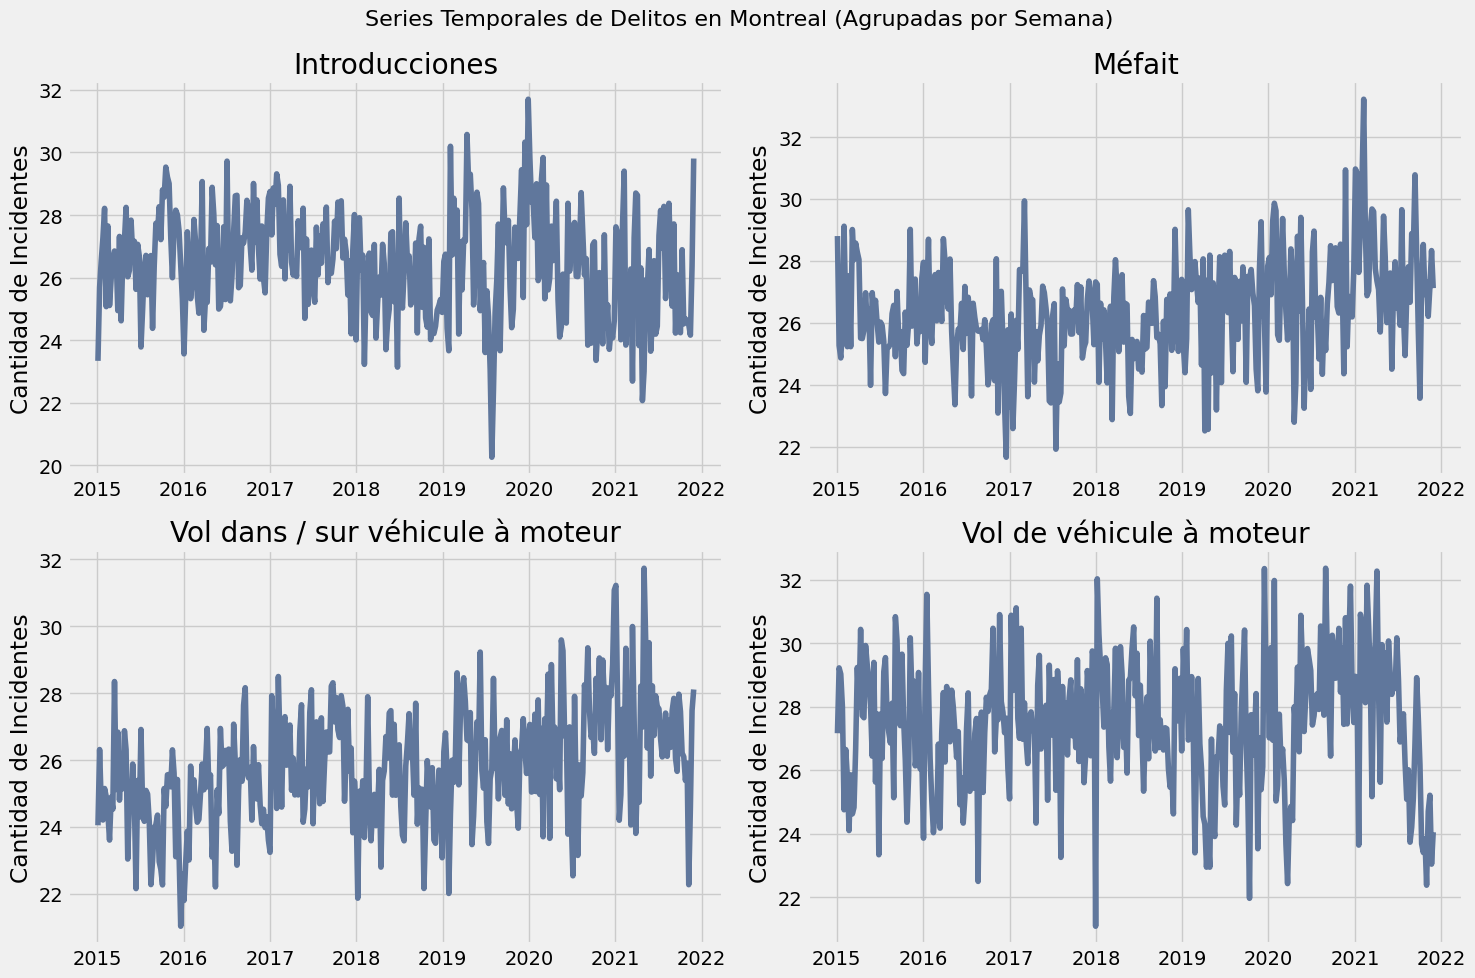

In [5]:
# Visualización de las series temporales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Series Temporales de Delitos en Montreal (Agrupadas por Semana)', fontsize=16)

# Serie 1: Introduction
axes[0,0].plot(y_s1.index, y_s1['pdq'])
axes[0,0].set_title('Introducciones')
axes[0,0].set_ylabel('Cantidad de Incidentes')
axes[0,0].grid(True)

# Serie 2: Méfait (Daños)
axes[0,1].plot(y_s2.index, y_s2['pdq'])
axes[0,1].set_title('Méfait')
axes[0,1].set_ylabel('Cantidad de Incidentes')
axes[0,1].grid(True)

# Serie 3: Vol dans/sur véhicule à moteur (Robo en/de un vehículo de motor)
axes[1,0].plot(y_s3.index, y_s3['pdq'])
axes[1,0].set_title('Vol dans / sur véhicule à moteur')
axes[1,0].set_ylabel('Cantidad de Incidentes')
axes[1,0].grid(True)

# Serie 4: Vol de véhicule à moteur (Robo de vehículos de motor)
axes[1,1].plot(y_s4.index, y_s4['pdq'])
axes[1,1].set_title('Vol de véhicule à moteur')
axes[1,1].set_ylabel('Cantidad de Incidentes')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

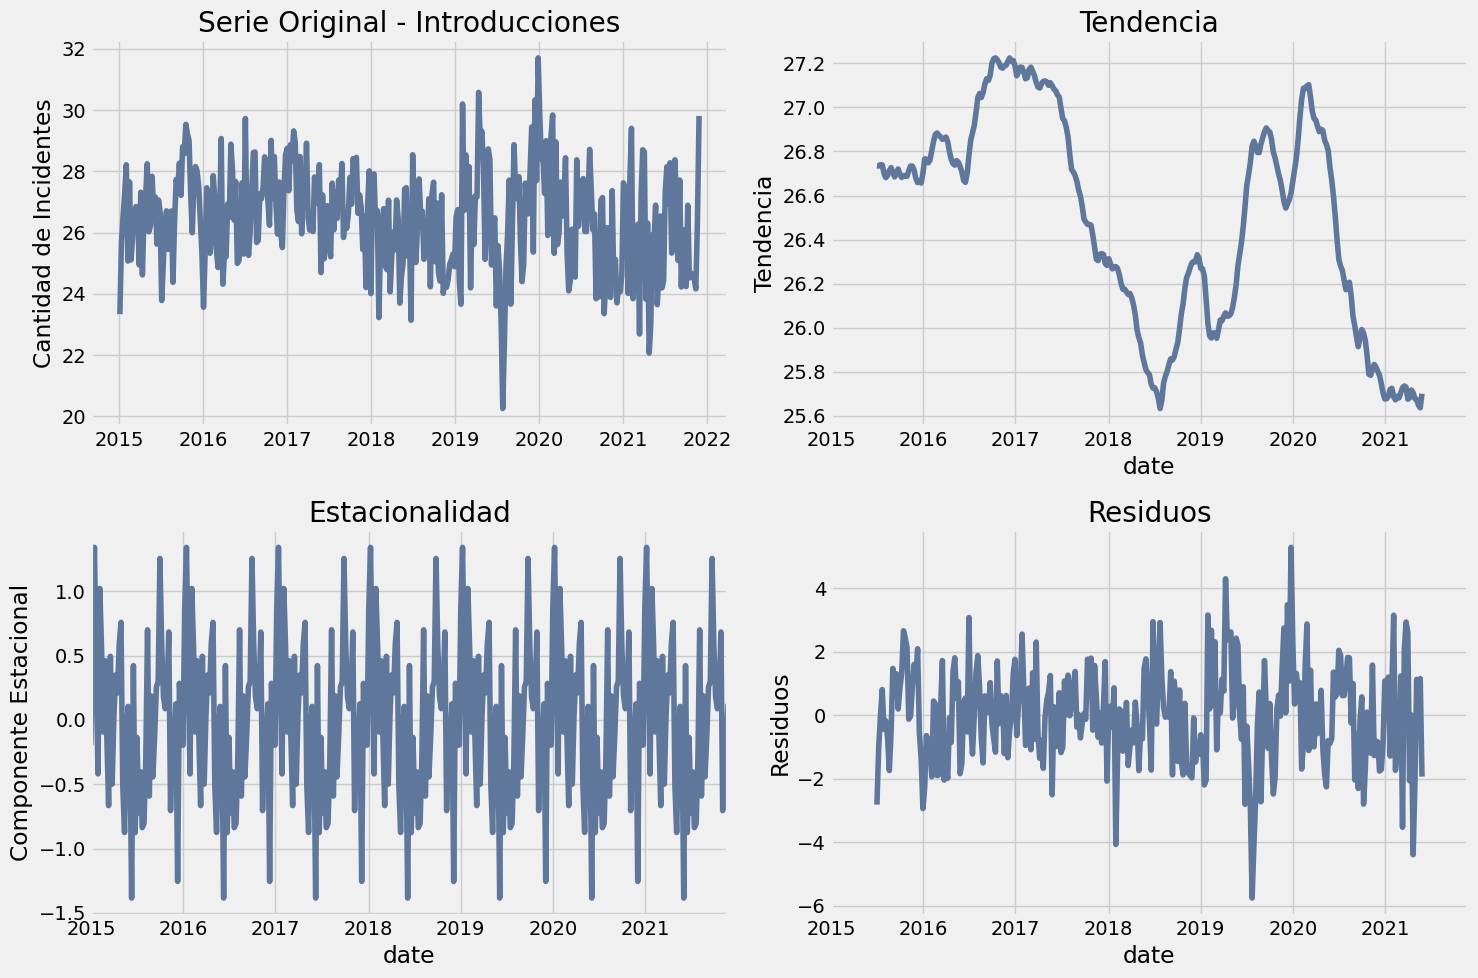

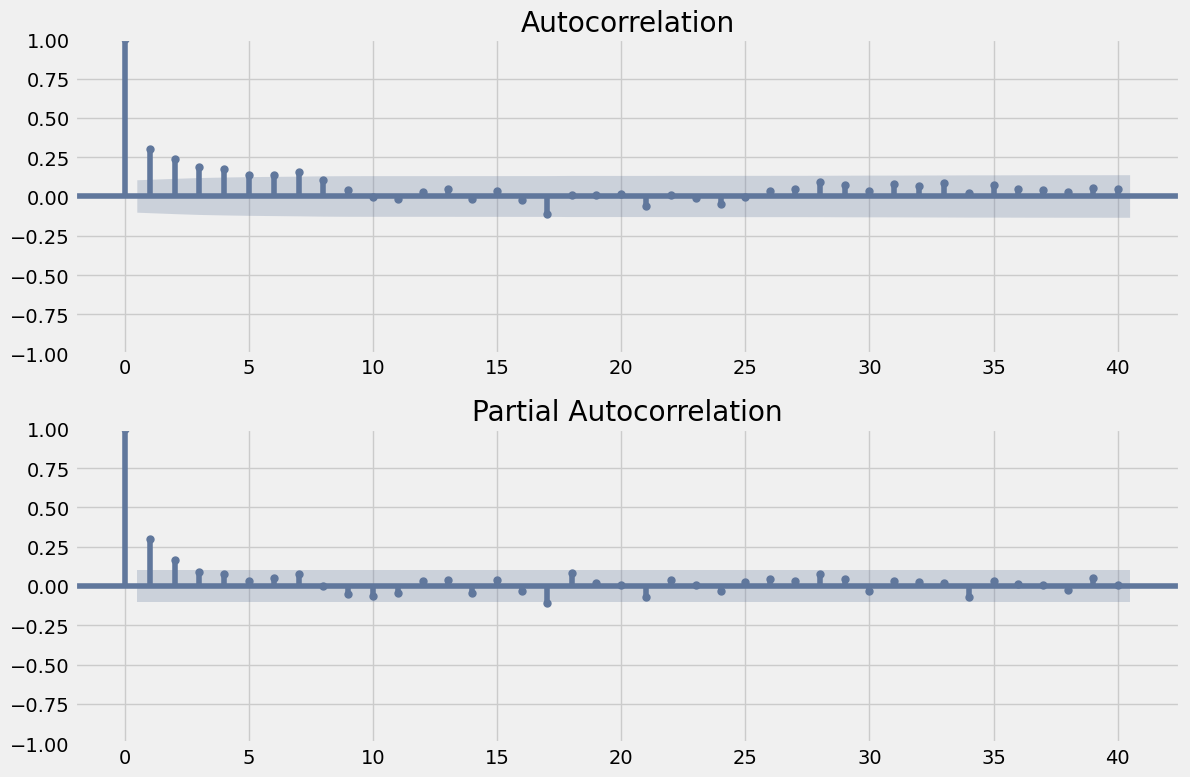

,model,order,seasonal_order,mae,rmse,mape
5,"SARIMA_(0,0,0)X(1,0,1,12)","(0, 0, 0)","(1, 0, 1, 12)",1.587567,1.849976,6.223442
13,"SARIMA_(0,0,1)X(1,0,1,12)","(0, 0, 1)","(1, 0, 1, 12)",1.593371,1.852144,6.239636
37,"SARIMA_(1,0,0)X(1,0,1,12)","(1, 0, 0)","(1, 0, 1, 12)",1.602059,1.858404,6.266621
3,"SARIMA_(0,0,0)X(0,1,1,12)","(0, 0, 0)","(0, 1, 1, 12)",1.644430,1.945057,6.537969
7,"SARIMA_(0,0,0)X(1,1,1,12)","(0, 0, 0)","(1, 1, 1, 12)",1.644440,1.945068,6.538011


In [15]:
import numpy as np
import pandas as pd
from math import sqrt

# Seleccionamos la serie "Introduction":
y_selected = y_s1.copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Serie original
axes[0,0].plot(y_selected.index, y_selected['pdq'])
axes[0,0].set_title('Serie Original - Introducciones')
axes[0,0].set_ylabel('Cantidad de Incidentes')

# Descomposición estacional
decomposition = sm.tsa.seasonal_decompose(y_selected['pdq'], model='additive', period=52)
decomposition.trend.plot(ax=axes[0,1], title='Tendencia')
axes[0,1].set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=axes[1,0], title='Estacionalidad')
axes[1,0].set_ylabel('Componente Estacional')

decomposition.resid.plot(ax=axes[1,1], title='Residuos')
axes[1,1].set_ylabel('Residuos')

plt.tight_layout()
plt.show()

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(y_selected['pdq'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(y_selected['pdq'], lags=40, ax=ax2)
plt.tight_layout()
plt.show()


target_date_ts = pd.to_datetime(target_date)
resultados = []

for p in params:
    try:
        modelo = SarimaModels(p)

        # obtener DataFrame de test con columnas 'y' y 'yhat'
        df_tmp = modelo.df_testig(y_selected, target_date_ts)

        y_true = df_tmp['y'].astype(float).values
        y_pred = df_tmp['yhat'].astype(float).values

        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        mask = np.abs(y_true) > 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

        resultados.append({
            'model': modelo.name_model,
            'order': str(p[0]),
            'seasonal_order': str(p[1]),
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        })

df_results = pd.DataFrame(resultados)
df_results.sort_values('mae', ascending=True, inplace=True)
df_results.head()

**R:** A partir del gráfico de tendencia, podemos ver claramente como cae entre los años 2015-2019, luego se recupera entre 2019-2020 y se vuelve a descompensar en el último tramo 2020-2021.

Desde el gráfico de estacionalidad, notamos una componente estacional muy marcada durante ciertas épocas anuales con una amplitud significativa.

Por último, los residuos tienen una variabilidad relativamente constante y una magnitud moderada, indicando que el modelo de descomposición explica una porción significativa de la variabilidad.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [18]:
from prophet import Prophet

import ast
from math import sqrt
import numpy as np
import pandas as pd

best = df_results.sort_values('mae').iloc[0]
order = ast.literal_eval(best['order'])
seasonal_order = ast.literal_eval(best['seasonal_order'])
best_params = (tuple(order), tuple(seasonal_order))

# obtener predicciones y métricas del mejor SARIMA
sarima_model = SarimaModels(best_params)
df_sarima = sarima_model.df_testig(y_selected, pd.to_datetime(target_date))
y_s = df_sarima['y'].astype(float).values
yhat_s = df_sarima['yhat'].astype(float).values
mae_s = np.mean(np.abs(y_s - yhat_s))
rmse_s = np.sqrt(np.mean((y_s - yhat_s)**2))
mask = np.abs(y_s) > 0
mape_s = np.mean(np.abs((y_s[mask] - yhat_s[mask]) / y_s[mask]))*100 if mask.sum()>0 else np.nan

df_prop = y_selected.reset_index().copy()
df_prop = df_prop.rename(columns={'date':'ds','pdq':'y'})
train_prop = df_prop[df_prop['ds'] < pd.to_datetime(target_date)]
test_prop  = df_prop[df_prop['ds'] >= pd.to_datetime(target_date)]

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_prop)

# predecir para las fechas de test
future = m.make_future_dataframe(periods=len(test_prop), freq='W')
fcst = m.predict(future)
df_fcst = fcst[['ds','yhat']].merge(test_prop[['ds','y']], on='ds', how='right').sort_values('ds')
y_p = df_fcst['y'].astype(float).values
yhat_p = df_fcst['yhat'].astype(float).values
mae_p = np.mean(np.abs(y_p - yhat_p))
rmse_p = np.sqrt(np.mean((y_p - yhat_p)**2))
maskp = np.abs(y_p) > 0
mape_p = np.mean(np.abs((y_p[maskp] - yhat_p[maskp]) / y_p[maskp]))*100 if maskp.sum()>0 else np.nan

df_compare = pd.DataFrame([
    {'model':'SARIMA_best', 'mae':mae_s, 'rmse':rmse_s, 'mape':mape_s, 'params_order':order, 'params_seasonal':seasonal_order},
    {'model':'Prophet',     'mae':mae_p, 'rmse':rmse_p, 'mape':mape_p, 'params_order':None, 'params_seasonal':None}
])
display(df_compare)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpji8qawqq/h0lazthv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpji8qawqq/ful7qdk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54963', 'data', 'file=/tmp/tmpji8qawqq/h0lazthv.json', 'init=/tmp/tmpji8qawqq/ful7qdk7.json', 'output', 'file=/tmp/tmpji8qawqq/prophet_modela0bouy16/prophet_model-20251025025930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:59:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,model,mae,rmse,mape,params_order,params_seasonal
0,SARIMA_best,1.587567,1.849976,6.223442,"(0, 0, 0)","(1, 0, 1, 12)"
1,Prophet,1.707865,2.032361,6.701037,None,None


**R:** Los resultados muestran que el mejor modelo SARIMA obtiene errores algo menores (MAE 1.59 vs 1.71, RMSE 1.85 vs 2.03, MAPE 6.22% vs 6.70%) que prophet, lo que indica una ligera ventaja en exactitud predictiva.

Teóricamente, SARIMA tiene una estructura lineal ARMA con estacionalidad explícita y requiere estacionariedad junto a diagnóstico de residuos; Prophet modela tendencia por tramos y estacionalidades aditivas (más componentes y feriados), es más robusto a cambios de tendencia y generalmente más automático de usar. En cuanto a la implementación, Prophet es más sencillo y rápido de poner en producción sin muchas complicaciones, mientras que SARIMA exige análisis de ACF/PACF y ajuste fino pero proporciona parámetros interpretables de dependencia temporal. En conclusión, Prophet será preferible cuando haya cambios de tendencia, efectos de calendario (por ejemplo feriados o festivos), múltiples estacionalidades o necesidad de un flujo rápido y robusto; preferiría SARIMA cuando la serie sea bien explicada por dependencia ARMA clara, se necesite interpretación de parámetros o cuando se busque exprimir la máxima precisión en correlaciones a corto plazo como en este experimento.